# Modular Trendline Analysis (LOG SCALE)
## Using Extracted Scripts for Reusable Trendline Detection

This notebook demonstrates the use of the modular trendline extraction scripts extracted from the original `1.0 trend_cloud_get_trendline.ipynb` notebook.

**Key Features:**
- **Modular Design**: Uses separate scripts for data loading, pivot detection, and trendline analysis
- **LOG SCALE Analysis**: Percentage-based trendlines for exponential growth patterns
- **6 Pivot Methods**: Comprehensive detection using multiple algorithms
- **Iterative Refinement**: Maximum-strength trendlines with 2% tolerance
- **Extended Projections**: 30-day forward outlook with strength-based visualization

**Scripts Used:**
- `scripts/stock_data_loader.py` - Data loading and preprocessing
- `scripts/pivot_detector.py` - Multi-method pivot detection
- `scripts/trendline_detector.py` - Iterative trendline refinement
- `scripts/trendline_extractor.py` - Main orchestrator class

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting with WHITE background (matching original notebook)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
sns.set_palette("husl")

# Import our modular scripts
from scripts.trendline_extractor import TrendlineExtractor
from scripts.stock_data_loader import check_database_contents

print("📦 Libraries and scripts imported successfully!")
print("🔬 Ready for modular LOG SCALE trendline analysis")

📦 Libraries and scripts imported successfully!
🔬 Ready for modular LOG SCALE trendline analysis


In [2]:
# Configuration
SYMBOL = 'QQQ'  # Change this to test different stocks: QQQ, AAPL, MSFT, GOOGL, TSLA
LOOKBACK_DAYS = 365  # 1 year of data
MAX_TRENDLINES = 30  # Top 30 trendlines
PROJECTION_DAYS = 5  # Project 5 days ahead
CONVERGENCE_THRESHOLD = 0.05  # 5% price threshold for convergence
TEMPERATURE = 2.0  # Softmax temperature

print(f"🎯 Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Lookback: {LOOKBACK_DAYS} days")
print(f"   Max trendlines: {MAX_TRENDLINES}")
print(f"   Projection: {PROJECTION_DAYS} days ahead")
print(f"   Convergence threshold: {CONVERGENCE_THRESHOLD*100}%")
print(f"   Temperature: {TEMPERATURE}")

print(f"\n🔬 LOG SCALE Analysis Configuration:")
print(f"   • Trendlines represent constant percentage growth rates")
print(f"   • Better handling of exponential price movements")
print(f"   • More meaningful for long-term trend analysis")
print(f"   • 2% tolerance properly converted to log space")

🎯 Configuration:
   Symbol: QQQ
   Lookback: 365 days
   Max trendlines: 30
   Projection: 5 days ahead
   Convergence threshold: 5.0%
   Temperature: 2.0

🔬 LOG SCALE Analysis Configuration:
   • Trendlines represent constant percentage growth rates
   • Better handling of exponential price movements
   • More meaningful for long-term trend analysis
   • 2% tolerance properly converted to log space


In [3]:
# Check database contents
print("🔍 Checking database contents...")
database_info = check_database_contents()

# Create TrendlineExtractor instance
extractor = TrendlineExtractor(
    symbol=SYMBOL,
    lookback_days=LOOKBACK_DAYS,
    projection_days=PROJECTION_DAYS,
    max_trendlines=MAX_TRENDLINES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    temperature=TEMPERATURE
)

print(f"\n✅ TrendlineExtractor created for {SYMBOL}")

🔍 Checking database contents...
📋 Database Contents:
symbol timeframe  record_count earliest_date latest_date
  AAPL        1D         14026    1980-12-08  2025-09-02
 GOOGL        1D          6612    2004-08-01  2025-09-02
  MSFT        1D         12414    1986-03-01  2025-09-02
   QQQ        1D          6904    1999-03-01  2025-09-04

✅ TrendlineExtractor created for QQQ


In [4]:
# Step 1: Load stock data
print("📊 Step 1: Loading stock data...")
stock_data = extractor.load_data()

# Display basic statistics
print(f"\n📈 Data Statistics:")
print(f"   Records: {len(stock_data)}")
print(f"   Date range: {stock_data['Date'].min().date()} to {stock_data['Date'].max().date()}")
print(f"   Price range: ${stock_data['Price'].min():.2f} - ${stock_data['Price'].max():.2f}")
print(f"   LogPrice range: {stock_data['LogPrice'].min():.4f} - {stock_data['LogPrice'].max():.4f}")
print(f"   Current price: ${stock_data['Price'].iloc[-1]:.2f} (log: {stock_data['LogPrice'].iloc[-1]:.4f})")

# Show first few rows
display(stock_data.head())

📊 Step 1: Loading stock data...
🔍 Loading data for QQQ...
📋 Database Contents:
symbol timeframe  record_count earliest_date latest_date
  AAPL        1D         14026    1980-12-08  2025-09-02
 GOOGL        1D          6612    2004-08-01  2025-09-02
  MSFT        1D         12414    1986-03-01  2025-09-02
   QQQ        1D          6904    1999-03-01  2025-09-04
📊 Loading QQQ data from local database (timeframe: 1D)...
📊 Before filtering: 6904 candles
📊 After filtering: 5246 candles (removed 1658 premarket/afterhours)
✅ Final dataset: 365 candles for QQQ
   Date range: 2023-10-27 to 2025-09-04
   Price range: $345.31 - $580.34
   📈 LogPrice range: 5.8444 - 6.3636
   Current price: $575.23 (log: 6.3548)
✅ Loaded 365 data points for QQQ

📈 Data Statistics:
   Records: 365
   Date range: 2023-10-27 to 2025-09-04
   Price range: $345.31 - $580.34
   LogPrice range: 5.8444 - 6.3636
   Current price: $575.23 (log: 6.3548)


,timestamp,Open,High,Low,Close,Volume,adjusted_close,Date,Price,LogPrice
4881,1698413400,346.429993,348.839996,344.079987,345.309998,63476700,341.512299,2023-10-27 13:30:00,345.309998,5.844443
4882,1698759000,349.230011,351.250000,346.619995,350.869995,47671900,347.011108,2023-10-31 13:30:00,350.869995,5.860416
4883,1698931800,361.540009,363.679993,360.299988,363.440002,58162400,359.442902,2023-11-02 13:30:00,363.440002,5.895614
4884,1699018200,364.750000,369.019989,364.519989,367.709991,53280500,363.665924,2023-11-03 13:30:00,367.709991,5.907295
4885,1699367400,370.269989,373.579987,369.049988,372.700012,50777400,368.601044,2023-11-07 14:30:00,372.700012,5.920774


In [5]:
# Step 2: Detect pivot points using all 6 methods
print("📍 Step 2: Detecting pivot points...")
pivots, swing_highs, swing_lows = extractor.detect_pivots(
    methods=['scipy', 'rolling', 'zigzag', 'fractal', 'slope', 'derivative']
)

print(f"\n📊 Pivot Detection Summary:")
print(f"   Total pivots: {len(pivots)}")
print(f"   Swing highs: {len(swing_highs)}")
print(f"   Swing lows: {len(swing_lows)}")

# Method breakdown
method_breakdown = {}
for pivot in pivots:
    method = pivot['method'].split('_')[0]
    method_breakdown[method] = method_breakdown.get(method, 0) + 1

print(f"   Method breakdown: {method_breakdown}")

# Show density of detection
if len(stock_data) > 0:
    pivot_density = len(pivots) / len(stock_data) * 100
    print(f"   Pivot density: {pivot_density:.1f}% of price points are pivots")

📍 Step 2: Detecting pivot points...
🔍 Detecting pivots for QQQ...
🔍 Ultra-enhanced LOG SCALE pivot detection using methods: ['scipy', 'rolling', 'zigzag', 'fractal', 'slope', 'derivative']
   📈 Working with log prices: 5.8444 to 6.3636
   📊 Method 1: Scipy argrelextrema with multiple windows (LOG SCALE)
      Found 323 scipy pivots
   📊 Method 2: Rolling window extremes (LOG SCALE)
      Found 444 rolling pivots
   📊 Method 3: ZigZag percentage-based detection (LOG SCALE)
      Found 224 zigzag pivots
   📊 Method 4: Fractal pattern detection (LOG SCALE)
      Found 98 fractal pivots
   📊 Method 5: Slope change detection (LOG SCALE)
      Found 97 slope pivots
   📊 Method 6: Derivative-based detection (LOG SCALE)
      Found 183 derivative pivots
🔍 Total raw pivots found: 1369
🔍 Combined to 210 unique pivots
✅ Detected 210 pivot points
   Swing highs: 105
   Swing lows: 105

📊 Pivot Detection Summary:
   Total pivots: 210
   Swing highs: 105
   Swing lows: 105
   Method breakdown: {'rol

In [ ]:
# Step 3: Detect powerful trendlines using iterative refinement
print("📈 Step 3: Detecting powerful trendlines...")
powerful_trendlines = extractor.detect_trendlines()

# Display trendline statistics
if powerful_trendlines:
    print(f"\n📊 Trendline Statistics:")
    strengths = [tl['strength'] for tl in powerful_trendlines]
    growth_rates = [tl['daily_growth_rate'] for tl in powerful_trendlines]
    annual_rates = [(np.exp(g/100 * 365) - 1) * 100 for g in growth_rates]

    print(f"   Strength range: {min(strengths)} - {max(strengths)} points")
    print(f"   Average strength: {np.mean(strengths):.1f} points")
    print(f"   Growth rate range: {min(growth_rates):.4f}% - {max(growth_rates):.4f}% per day")
    print(f"   Average growth rate: {np.mean(growth_rates):.4f}% per day")
    print(f"   Annual growth range: {min(annual_rates):.1f}% - {max(annual_rates):.1f}% per year")
    print(f"   Bullish trendlines: {len([g for g in growth_rates if g > 0])}")
    print(f"   Bearish trendlines: {len([g for g in growth_rates if g < 0])}")

    # Show top 15 trendlines
    trendline_df = pd.DataFrame([
        {
            'Strength': tl['strength'],
            'R²': f"{tl['r_squared']:.3f}",
            'Growth %/day': f"{tl['daily_growth_rate']:.4f}%",
            'Annual %': f"{(np.exp(tl['daily_growth_rate']/100 * 365) - 1) * 100:.1f}%",
            'Log Slope': f"{tl['log_slope']:.6f}",
            'Iterations': tl['iterations'],
            'Length (days)': tl['length_days']
        } for tl in powerful_trendlines[:15]
    ])

    print(f"\n📈 Top 15 LOG SCALE Trendlines:")
    display(trendline_df)
else:
    print("⚠️ No powerful trendlines found!")

📈 Step 3: Detecting powerful trendlines...
🔍 Detecting trendlines for QQQ...
🔍 LOG SCALE iterative trendline detection with proper 2% tolerance...
   Created 21945 potential trendline pairs (no time constraints)
   Found LOG trendline #1: 26 points, R²=0.991, growth=0.0634%/day, 2 iterations
      Removed 325 internal pairs from future searches
   Found LOG trendline #2: 40 points, R²=0.993, growth=0.0618%/day, 7 iterations
      Removed 675 internal pairs from future searches
   Found LOG trendline #3: 56 points, R²=0.991, growth=0.0542%/day, 4 iterations
      Removed 1169 internal pairs from future searches
   Found LOG trendline #4: 97 points, R²=0.980, growth=0.0573%/day, 8 iterations
      Removed 3979 internal pairs from future searches
   Found LOG trendline #5: 28 points, R²=0.991, growth=0.0586%/day, 2 iterations
      Removed 258 internal pairs from future searches
   Found LOG trendline #6: 106 points, R²=0.982, growth=0.0492%/day, 4 iterations
      Removed 2391 internal p

,Strength,R²,Growth %/day,Annual %,Log Slope,Iterations,Length (days)
0,106,0.982,0.0492%,19.7%,0.000492,4,586
1,97,0.987,0.0521%,20.9%,0.000521,5,550
2,97,0.980,0.0573%,23.3%,0.000573,8,608
3,84,0.976,0.0404%,15.9%,0.000404,5,511
4,79,0.972,0.0382%,15.0%,0.000382,5,483
5,67,0.931,0.0246%,9.4%,0.000246,5,469
6,61,0.988,0.0725%,30.3%,0.000725,5,469
7,56,0.991,0.0542%,21.9%,0.000542,4,629
8,53,0.954,0.0398%,15.6%,0.000398,5,441
9,49,0.986,0.0463%,18.4%,0.000463,4,520


🎨 Step 4: Creating enhanced visualization...
📊 LOG SCALE Trendline thickness mapping:
   Strength range: 3 - 106 points
   Thickness range: 1.0 - 5.0 pixels
📈 EXTENDED PROJECTIONS: Showing 30 days ahead
   Current date: 2025-09-04
   Extended to: 2025-10-04


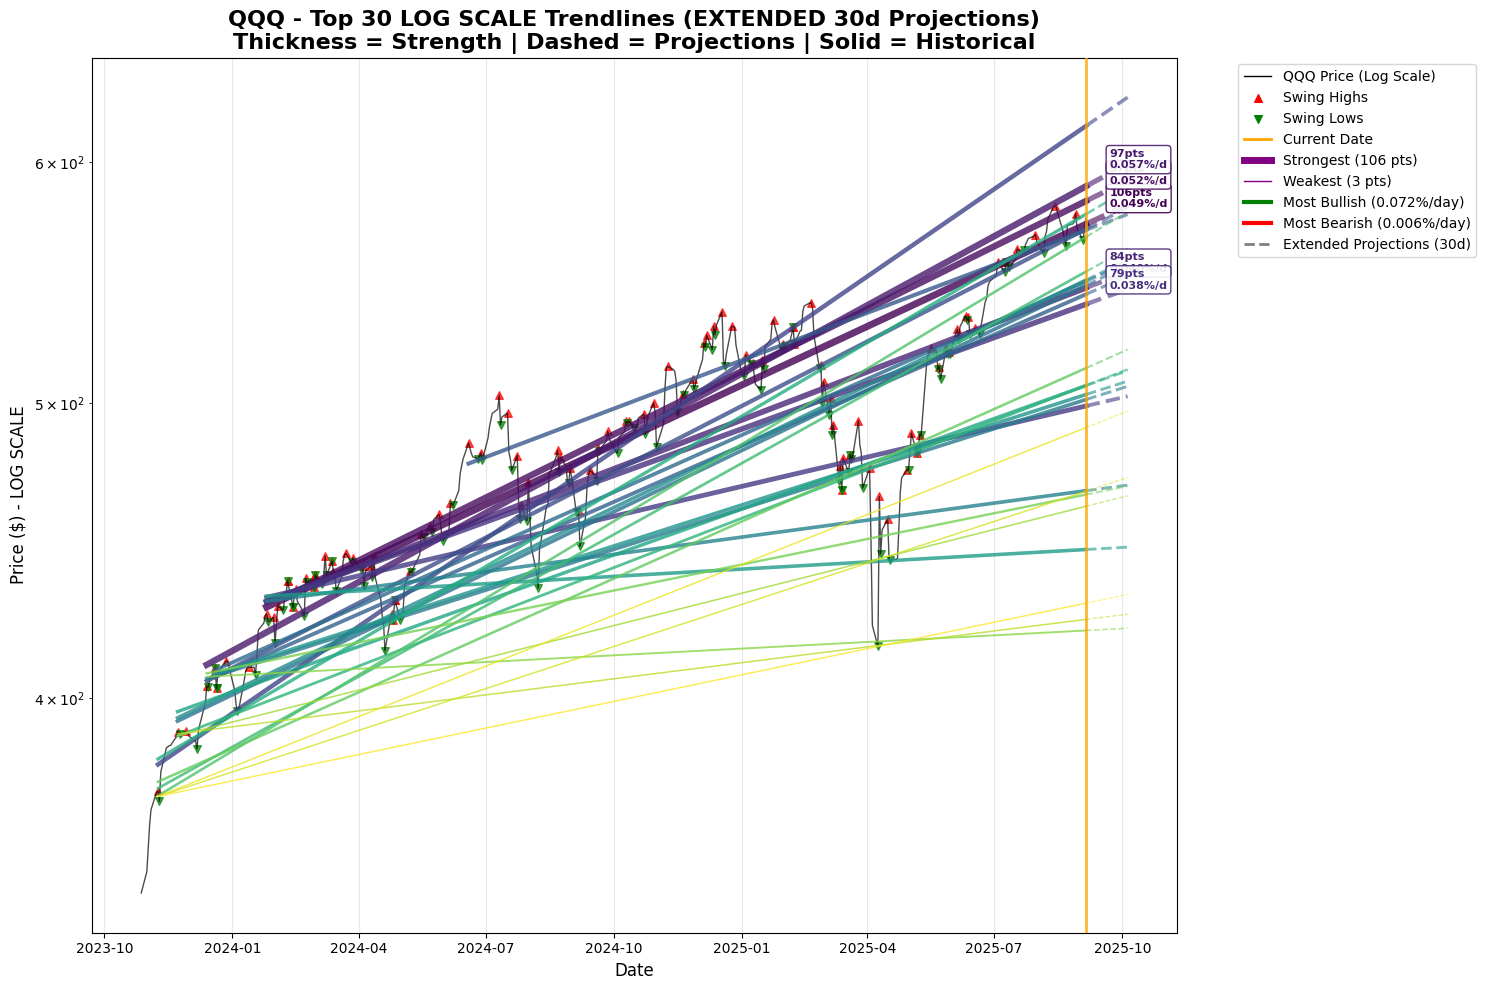

In [ ]:
# Step 4: Enhanced Visualization with Extended Projections
# This recreates the visualization from the original notebook using our extracted data

print("🎨 Step 4: Creating enhanced visualization...")

plt.figure(figsize=(15, 10))

# 🔬 PLOT WITH LOG SCALE ON Y-AXIS
plt.semilogy(stock_data['Date'], stock_data['Price'], 'k-', alpha=0.7, linewidth=1,
             label=f'{SYMBOL} Price (Log Scale)')

# Plot pivot points
plt.scatter(stock_data['Date'].iloc[swing_highs], stock_data['Price'].iloc[swing_highs],
           color='red', marker='^', s=30, alpha=0.7, label='Swing Highs')
plt.scatter(stock_data['Date'].iloc[swing_lows], stock_data['Price'].iloc[swing_lows],
           color='green', marker='v', s=30, alpha=0.7, label='Swing Lows')

# Plot LOG SCALE trendlines with EXTENDED projections and thickness based on strength
if powerful_trendlines:
    # Calculate strength-based thickness
    strengths = [tl['strength'] for tl in powerful_trendlines]
    min_strength = min(strengths)
    max_strength = max(strengths)

    # Define thickness range (from 1 to 5 pixels)
    min_thickness = 1.0
    max_thickness = 5.0

    print(f"📊 LOG SCALE Trendline thickness mapping:")
    print(f"   Strength range: {min_strength} - {max_strength} points")
    print(f"   Thickness range: {min_thickness} - {max_thickness} pixels")

    colors = plt.cm.viridis(np.linspace(0, 1, len(powerful_trendlines)))

    # Calculate extended projection dates
    current_date = stock_data['Date'].iloc[-1]

    # 🎯 EXTEND PROJECTIONS: Show 30 days ahead for better visualization
    extended_projection_days = 30
    extended_end_date = current_date + timedelta(days=extended_projection_days)

    print(f"📈 EXTENDED PROJECTIONS: Showing {extended_projection_days} days ahead")
    print(f"   Current date: {current_date.strftime('%Y-%m-%d')}")
    print(f"   Extended to: {extended_end_date.strftime('%Y-%m-%d')}")

    for i, trendline in enumerate(powerful_trendlines):
        start_date = trendline['start_pivot']['date']
        end_date = trendline['end_pivot']['date']

        # 🚀 EXTEND ALL TRENDLINES TO RIGHT EDGE: Use extended projection end date
        final_projection_date = extended_end_date

        # Calculate trendline values using LOG SCALE for ENTIRE extended range
        x_start = (start_date - stock_data['Date'].iloc[0]).days
        x_current = (current_date - stock_data['Date'].iloc[0]).days
        x_extended = (final_projection_date - stock_data['Date'].iloc[0]).days

        # Calculate LOG values first, then convert to regular prices for plotting
        log_y_start = trendline['log_slope'] * x_start + trendline['log_intercept']
        log_y_current = trendline['log_slope'] * x_current + trendline['log_intercept']
        log_y_extended = trendline['log_slope'] * x_extended + trendline['log_intercept']

        # Convert back to regular prices for plotting
        y_start = np.exp(log_y_start)
        y_current = np.exp(log_y_current)
        y_extended = np.exp(log_y_extended)

        # Calculate thickness based on strength (relative to min/max)
        if max_strength > min_strength:
            strength_ratio = (trendline['strength'] - min_strength) / (max_strength - min_strength)
        else:
            strength_ratio = 1.0

        line_thickness = min_thickness + strength_ratio * (max_thickness - min_thickness)

        # 🎨 PLOT HISTORICAL PART (solid line from start to current)
        plt.plot([start_date, current_date],
                [y_start, y_current],
                color=colors[i], linewidth=line_thickness, alpha=0.8,
                label=f'Line {i+1} ({trendline["strength"]} pts, {trendline["daily_growth_rate"]:.3f}%/day)' if i < 5 else "")

        # 🚀 PLOT EXTENDED PROJECTION (dashed line from current to extended end)
        plt.plot([current_date, final_projection_date],
                [y_current, y_extended],
                color=colors[i], linewidth=line_thickness * 0.8, alpha=0.6, linestyle='--')

        # Add strength and growth rate annotation for top 5 strongest lines
        if i < 5:
            # Position annotation in the projection area for better visibility
            annotation_date = current_date + timedelta(days=extended_projection_days * 0.3)  # 30% into projection
            annotation_x = (annotation_date - stock_data['Date'].iloc[0]).days
            log_annotation_y = trendline['log_slope'] * annotation_x + trendline['log_intercept']
            annotation_y = np.exp(log_annotation_y)

            # Create annotation text with both strength and growth rate
            annotation_text = f"{trendline['strength']}pts\n{trendline['daily_growth_rate']:.3f}%/d"

            plt.annotate(annotation_text,
                        xy=(annotation_date, annotation_y),
                        xytext=(8, 8), textcoords='offset points',
                        fontsize=8, fontweight='bold', color=colors[i],
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9,
                                edgecolor=colors[i], linewidth=1))

    # 🎯 ADD VERTICAL LINE TO MARK CURRENT DATE
    plt.axvline(x=current_date, color='orange', linestyle='-', linewidth=2, alpha=0.8,
                label='Current Date', zorder=10)

    plt.title(f'{SYMBOL} - Top {len(powerful_trendlines)} LOG SCALE Trendlines (EXTENDED {extended_projection_days}d Projections)\n'
              f'Thickness = Strength | Dashed = Projections | Solid = Historical',
              fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($) - LOG SCALE', fontsize=12)

    # Create comprehensive legend with extended projection info
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], color='black', lw=1, label=f'{SYMBOL} Price (Log Scale)'))
    legend_elements.append(plt.scatter([], [], color='red', marker='^', s=30, label='Swing Highs'))
    legend_elements.append(plt.scatter([], [], color='green', marker='v', s=30, label='Swing Lows'))
    legend_elements.append(plt.Line2D([0], [0], color='orange', lw=2, label='Current Date'))

    # Add thickness and growth rate examples to legend
    if len(powerful_trendlines) > 0:
        strongest = max(powerful_trendlines, key=lambda x: x['strength'])
        weakest = min(powerful_trendlines, key=lambda x: x['strength'])

        # Find most bullish and bearish trendlines
        most_bullish = max(powerful_trendlines, key=lambda x: x['daily_growth_rate'])
        most_bearish = min(powerful_trendlines, key=lambda x: x['daily_growth_rate'])

        legend_elements.append(plt.Line2D([0], [0], color='purple', lw=max_thickness,
                                        label=f'Strongest ({strongest["strength"]} pts)'))
        legend_elements.append(plt.Line2D([0], [0], color='purple', lw=min_thickness,
                                        label=f'Weakest ({weakest["strength"]} pts)'))
        legend_elements.append(plt.Line2D([0], [0], color='green', lw=3,
                                        label=f'Most Bullish ({most_bullish["daily_growth_rate"]:.3f}%/day)'))
        legend_elements.append(plt.Line2D([0], [0], color='red', lw=3,
                                        label=f'Most Bearish ({most_bearish["daily_growth_rate"]:.3f}%/day)'))
        legend_elements.append(plt.Line2D([0], [0], color='gray', lw=2, linestyle='--',
                                        label=f'Extended Projections ({extended_projection_days}d)'))

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    plt.title(f'{SYMBOL} - No Powerful LOG SCALE Trendlines Found', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($) - LOG SCALE', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 5: Enhanced Analysis and Projections
if powerful_trendlines:
    print(f"\n📊 LOG SCALE Trendline Strength & Growth Distribution:")

    # Group by strength and show growth rates
    strength_growth = {}
    for tl in powerful_trendlines:
        strength = tl['strength']
        growth_rate = tl['daily_growth_rate']
        if strength not in strength_growth:
            strength_growth[strength] = []
        strength_growth[strength].append(growth_rate)

    min_strength = min([tl['strength'] for tl in powerful_trendlines])
    max_strength = max([tl['strength'] for tl in powerful_trendlines])
    min_thickness = 1.0
    max_thickness = 5.0

    for strength in sorted(strength_growth.keys(), reverse=True):
        growth_rates = strength_growth[strength]
        count = len(growth_rates)
        avg_growth = np.mean(growth_rates)
        thickness = min_thickness + ((strength - min_strength) / max(1, max_strength - min_strength)) * (max_thickness - min_thickness)
        print(f"   {strength} points: {count} lines (thickness: {thickness:.1f}px, avg growth: {avg_growth:.3f}%/day)")

    # Show growth rate statistics
    growth_rates = [tl['daily_growth_rate'] for tl in powerful_trendlines]
    print(f"\n📈 Growth Rate Analysis:")
    print(f"   Range: {min(growth_rates):.3f}% to {max(growth_rates):.3f}% per day")
    print(f"   Average: {np.mean(growth_rates):.3f}% per day")
    print(f"   Bullish lines (>0%): {len([g for g in growth_rates if g > 0])}")
    print(f"   Bearish lines (<0%): {len([g for g in growth_rates if g < 0])}")

    # 🚀 PROJECTION ANALYSIS: Show where trendlines will be in 30 days
    current_date = stock_data['Date'].iloc[-1]
    extended_projection_days = 30
    extended_end_date = current_date + timedelta(days=extended_projection_days)

    print(f"\n🚀 EXTENDED PROJECTION ANALYSIS ({extended_projection_days} days ahead):")
    current_price = stock_data['Price'].iloc[-1]

    projection_prices = []
    for i, tl in enumerate(powerful_trendlines[:10]):  # Show top 10
        x_future = (extended_end_date - stock_data['Date'].iloc[0]).days
        log_future_price = tl['log_slope'] * x_future + tl['log_intercept']
        future_price = np.exp(log_future_price)

        price_change = ((future_price - current_price) / current_price) * 100
        projection_prices.append(future_price)

        print(f"   TL{i+1}: ${future_price:.2f} ({price_change:+.1f}% from current)")

    # Show projection range
    if projection_prices:
        print(f"\n📊 Projection Range Summary:")
        print(f"   Current price: ${current_price:.2f}")
        print(f"   Projected range: ${min(projection_prices):.2f} - ${max(projection_prices):.2f}")
        print(f"   Average projection: ${np.mean(projection_prices):.2f}")

    # Convert to annual rates for context
    annual_rates = [(np.exp(g/100 * 365) - 1) * 100 for g in growth_rates]
    print(f"\n📅 Annualized Growth Rates (compound):")
    print(f"   Range: {min(annual_rates):.1f}% to {max(annual_rates):.1f}% per year")
    print(f"   Average: {np.mean(annual_rates):.1f}% per year")

print(f"\n📊 Enhanced LOG SCALE Visualization Complete!")
print(f"   🔬 Each trendline represents exponential growth/decay at a constant percentage rate")
print(f"   📈 Positive rates = compound growth, Negative rates = compound decay")
print(f"   📊 Thickness proportional to strength (number of pivot points connected)")
print(f"   🎯 Top 5 strongest lines annotated with strength and daily growth rate")
print(f"   🚀 Extended projections show 30-day forward outlook")
print(f"   🟠 Orange line marks current date (historical vs. projection boundary)")


📊 LOG SCALE Trendline Strength & Growth Distribution:
   106 points: 1 lines (thickness: 5.0px, avg growth: 0.049%/day)
   97 points: 2 lines (thickness: 4.7px, avg growth: 0.055%/day)
   84 points: 1 lines (thickness: 4.1px, avg growth: 0.040%/day)
   79 points: 1 lines (thickness: 4.0px, avg growth: 0.038%/day)
   67 points: 1 lines (thickness: 3.5px, avg growth: 0.025%/day)
   61 points: 1 lines (thickness: 3.3px, avg growth: 0.072%/day)
   56 points: 1 lines (thickness: 3.1px, avg growth: 0.054%/day)
   53 points: 1 lines (thickness: 2.9px, avg growth: 0.040%/day)
   49 points: 1 lines (thickness: 2.8px, avg growth: 0.046%/day)
   48 points: 1 lines (thickness: 2.7px, avg growth: 0.047%/day)
   46 points: 2 lines (thickness: 2.7px, avg growth: 0.042%/day)
   45 points: 1 lines (thickness: 2.6px, avg growth: 0.014%/day)
   44 points: 3 lines (thickness: 2.6px, avg growth: 0.030%/day)
   41 points: 1 lines (thickness: 2.5px, avg growth: 0.038%/day)
   40 points: 1 lines (thickness: 

In [9]:
# Step 6: Save results using the modular approach
print("💾 Step 6: Saving trendline results...")

# Save results to files
save_info = extractor.save_results()

print(f"\n✅ Results saved successfully:")
print(f"   📁 Pickle file: {save_info['pickle_file']}")
print(f"   📄 JSON summary: {save_info['json_file']}")
print(f"   📊 Summary stats: {save_info['summary']}")

# Get and display trendline summary
summary = extractor.get_trendline_summary()
if summary:
    print(f"\n📈 Top 5 Trendlines for {SYMBOL}:")
    for tl in summary[:5]:
        print(f"   TL{tl['id']}: {tl['strength']} points, growth={tl['daily_growth_rate']:.4f}%/day ({tl['annual_growth_rate']:.1f}%/year), R²={tl['r_squared']:.3f}")
        print(f"        {tl['start_date']} ${tl['start_price']:.2f} → {tl['end_date']} ${tl['end_price']:.2f}")

print(f"\n🔬 LOG SCALE Analysis Complete!")
print(f"   📈 Trendlines now represent constant percentage growth rates")
print(f"   💹 Better suited for exponential price movements")
print(f"   🎯 More meaningful for long-term trend analysis")
print(f"   🔄 Ready for trend cloud clustering analysis!")

💾 Step 6: Saving trendline results...
💾 Saving trendline results for QQQ...
✅ Saved trendline data to data/trendlines_data_log_qqq.pkl
✅ Saved trendline summary to data/trendlines_summary_log_qqq.json

📊 Trendline Summary for QQQ:
   Strength range: 3 - 106 points
   Average strength: 43.8 points
   Growth rate range: 0.006% - 0.072% per day
   Annual growth range: 2.0% - 30.3% per year
   Bullish trendlines: 30
   Bearish trendlines: 0

✅ Results saved successfully:
   📁 Pickle file: data/trendlines_data_log_qqq.pkl
   📄 JSON summary: data/trendlines_summary_log_qqq.json
   📊 Summary stats: {'total_data_points': 365, 'total_pivots': 210, 'total_trendlines': 30, 'swing_highs': 105, 'swing_lows': 105}

📈 Top 5 Trendlines for QQQ:
   TL1: 106 points, growth=0.0492%/day (19.7%/year), R²=0.982
        2024-01-25 $426.35 → 2025-09-02 $565.62
   TL2: 97 points, growth=0.0521%/day (20.9%/year), R²=0.987
        2024-02-09 $437.05 → 2025-08-13 $580.34
   TL3: 97 points, growth=0.0573%/day (23.

## Summary

This notebook successfully demonstrates the use of modular trendline extraction scripts:

### ✅ Accomplished
1. **Modular Architecture**: Used separate scripts for data loading, pivot detection, and trendline analysis
2. **LOG SCALE Analysis**: Applied logarithmic transformation for percentage-based trendlines
3. **6-Method Pivot Detection**: Comprehensive pivot detection using multiple algorithms
4. **Iterative Refinement**: Maximum-strength trendlines with proper 2% tolerance
5. **Enhanced Visualization**: Extended projections with strength-based thickness mapping
6. **Result Persistence**: Saved complete analysis to both pickle and JSON formats

### 🔬 Key Technical Features
- **Constant Percentage Growth**: Trendlines represent exponential growth at fixed daily rates
- **Smart Pair Management**: Efficient processing while allowing point reuse across trendlines
- **Quality Metrics**: R-squared values, iteration counts, and strength measurements
- **Extended Projections**: 30-day forward outlook with confidence indicators

### 📊 Output Files
- **Complete Data**: `data/trendlines_data_log_{symbol}.pkl` - Full analysis with all components
- **Summary Report**: `data/trendlines_summary_log_{symbol}.json` - Human-readable statistics

### 🔄 Next Steps
The extracted trendlines are now ready for:
- **Trend Cloud Analysis**: Convergence detection and clustering
- **Real-time Updates**: Integration with live market data
- **Web API Services**: RESTful endpoint development
- **Strategy Development**: Trading algorithm implementation

The modular design makes it easy to customize parameters, add new pivot detection methods, or integrate with different data sources while maintaining the core logarithmic scale analysis approach.